In [147]:
from helmet_assignment.score import NFLAssignmentScorer, check_submission
from helmet_assignment.features import add_track_features

import numpy as np
import pandas as pd
import itertools
import glob
import os
import cv2
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from multiprocessing import Pool
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import random
import collections
import time
import datetime
import sys
from collections import defaultdict
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 600)


In [148]:
# 载入数据

n_test_videos = len(os.listdir('nfl-health-and-safety-helmet-assignment/test/'))
# Run in debug mode unless during submission
if n_test_videos == 6:
    debug = True
else:
    debug = False

# Configurables
n_debug_samples = 1
random_state = 2025
CONF_THRE = 0.3
max_iter = 1000
DIG_STEP = 3
DIG_MAX = DIG_STEP*10

# Read in the data.

BASE_DIR = 'nfl-health-and-safety-helmet-assignment'

labels = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
if debug:
    tracking = pd.read_csv(f'{BASE_DIR}/train_player_tracking.csv')
    # helmets = pd.read_csv(f'{BASE_DIR}/train_baseline_helmets.csv')
    helmets=pd.read_csv('/home/shigb/nfl/yolov5/wbf_result.csv')
else:
    tracking = pd.read_csv(f'{BASE_DIR}/test_player_tracking.csv')
    helmets = pd.read_csv(f'{BASE_DIR}/test_baseline_helmets.csv')
    
tracking = add_track_features(tracking)
# tracking
helmets
labels

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer
0,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H90,245,21,327,29,None,False,False
1,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V79,310,21,345,12,None,False,False
2,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H97,410,21,323,29,None,False,False
3,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,None,False,False
4,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H50,518,21,212,28,None,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952082,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V20,637,19,77,21,None,False,False
952083,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V47,664,22,360,26,None,False,False
952084,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V24,755,22,416,23,None,False,False
952085,58107_004362_Sideline_99,58107,4362,Sideline,58107_004362_Sideline.mp4,99,V23,822,23,334,24,None,False,False


In [149]:
def add_cols(df):
    df['game_play'] = df['video_frame'].str.split('_').str[:2].str.join('_')
    if 'video' not in df.columns:
        df['video'] = df['video_frame'].str.split('_').str[:3].str.join('_') + '.mp4'
    return df

if debug:
    helmets = add_cols(helmets)
    labels = add_cols(labels)
    # Select `n_debug_samples` worth of videos to debug with
    sample_videos = labels['video'].drop_duplicates() \
        .sample(n_debug_samples, random_state=random_state).tolist()
    sample_gameplays = ['_'.join(x.split('_')[:2]) for x in sample_videos]
    tracking = tracking[tracking['game_play'].isin(sample_gameplays)]
    helmets = helmets[helmets['video'].isin(sample_videos)]
    labels = labels[labels['video'].isin(sample_videos)]
tracking.shape, helmets.shape, labels.shape

((6072, 18), (14739, 9), (10917, 15))

In [150]:
helmets

,video_frame,label,left,width,top,height,conf,game_play,video
0,58106_002918_Sideline_1,Helmet,743.0,20.0,144.0,18.0,0.050613,58106_002918,58106_002918_Sideline.mp4
1,58106_002918_Sideline_1,Helmet,811.0,12.0,188.0,42.0,0.053570,58106_002918,58106_002918_Sideline.mp4
2,58106_002918_Sideline_1,Helmet,747.0,14.0,130.0,34.0,0.102015,58106_002918,58106_002918_Sideline.mp4
3,58106_002918_Sideline_1,Helmet,755.0,12.0,146.0,31.0,0.112362,58106_002918,58106_002918_Sideline.mp4
4,58106_002918_Sideline_1,Helmet,765.0,15.0,181.0,18.0,0.162160,58106_002918,58106_002918_Sideline.mp4
...,...,...,...,...,...,...,...,...,...
14734,58106_002918_Sideline_99,Helmet,951.0,15.0,384.0,16.0,0.822649,58106_002918,58106_002918_Sideline.mp4
14735,58106_002918_Sideline_99,Helmet,859.0,16.0,449.0,16.0,0.822835,58106_002918,58106_002918_Sideline.mp4
14736,58106_002918_Sideline_99,Helmet,53.0,17.0,344.0,17.0,0.841620,58106_002918,58106_002918_Sideline.mp4
14737,58106_002918_Sideline_99,Helmet,642.0,17.0,436.0,18.0,0.843953,58106_002918,58106_002918_Sideline.mp4


In [151]:
# 运行deepsort，提取结果和特征
import sys
sys.path.append('easydict-master/easydict-master/')
# https://github.com/mikel-brostrom/Yolov5_DeepSort_Pytorch
sys.path.append('Yolov5_DeepSort_Pytorch/deep_sort_pytorch/')
from deep_sort.deep_sort import DeepSort
from utils.parser import get_config

def apply_deepsort(video_data,
                     video_dir,
                     video_name,
                     deepsort_config='/home/shigb/nfl/Yolov5_DeepSort_Pytorch/deep_sort_pytorch/configs/deep_sort.yaml',
                     plot=False,
                     plot_frames=[]):
    
    # Setup Deepsort
    cfg = get_config()
    cfg.merge_from_file(deepsort_config)    
    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
#                         nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    
    # Run through frames.
    fea_cols = []
    for i in range(512):
        fea_cols.append(f'feature{i+1}')
    
    deep_cols = ['left','top','right','bottom','deepsort_cluster','class', 'conf']
    outs = []
    
    cap = cv2.VideoCapture(f'{video_dir}/{video_name}')
    success, image = cap.read()
    frame = 1
    while success:
        video_frame = f"{video_name.split('.')[0]}_{frame}"
        d = video_data[video_data.video_frame == video_frame].reset_index(drop=True)
        d['x'] = (d['left'] + round(d['width'] / 2))
        d['y'] = (d['top'] + round(d['height'] / 2))
        xywhs = d[['x','y','width','height']].values
        confs = d['conf'].values.reshape((len(d), ))
#         confs = np.ones((len(d)))
        classes = np.ones(shape=(len(confs),))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        outputs, features = deepsort.update(xywhs, confs, classes, image)
        # print(outputs)
        deep_df = pd.DataFrame(outputs, columns=deep_cols)
        if len(outputs) == 0:
            features = deepsort.get_features(xywhs, image)
            df = pd.DataFrame(features, columns=fea_cols)
            df[deep_cols] = 0
            df['top'] = d['top'].values
            df['left'] = d['left'].values
            df['right'] = d['left'].values + d['width'].values
            df['bottom'] = d['top'].values + d['height'].values 
            df['conf'] = d['conf'].values
            
#             df['top'] = df['top'].astype(int)
#             df['left'] = df['left'].astype(int)
            
        else:
            fea_df = pd.DataFrame(features, columns=fea_cols)
            df = pd.merge(left=deep_df, right=fea_df, left_index=True, right_index=True, how='right')
#         df['video_frame'] = video_frame
#         print(deep_df)

#         if len(df) > 0:
#             # TODO Fix this messy merge
# #             print(df['left'].dtypes, d['left'].dtypes)
#             d = pd.merge_asof(df.sort_values(['left','top']),
#                               d.sort_values(['left','top']),
#                               on='left', suffixes=('','_deepsort'),
#                               direction='nearest')
        df['video_frame'] = d.video_frame.values[0]
        df['video'] = d.video.values[0]
        df['game_play'] = d['game_play'].values[0]
        df['width'] = df['right'] - df['left']
        df['height'] = df['bottom'] - df['top']
        outs.append(df) #['left','top','right','bottom','deepsort_cluster','class', 'conf',fea_df*512,'video_frame','video','game_play','width','height']
        # print(outs)
        success, image = cap.read()
        frame += 1
        
    cap.release()
    
    out_df = pd.concat(outs)
    return out_df


if debug:
    video_dir = 'nfl-health-and-safety-helmet-assignment/train/'
else:
    video_dir = 'nfl-health-and-safety-helmet-assignment/test/'

# Loop through test videos and apply. If in debug mode show the score change.
out_deepsort = None
for myvideo, video_data in tqdm(helmets[helmets.conf > 0.3].groupby('video'), total=helmets['video'].nunique()):
    print(f'==== {myvideo} ====')
    if debug:
        # Plot deepsort labels when in debug mode.
        out_fea = apply_deepsort(video_data, video_dir, myvideo, plot_frames=[10, 150, 250])
    else:
        out_fea = apply_deepsort(video_data, video_dir, myvideo)
    
    if out_deepsort is None:
        out_deepsort = out_fea
    else:
        out_deepsort = pd.concat([out_deepsort, out_fea])
    
# out_deepsort #[fea_df*512,'left','top','right','bottom','deepsort_cluster','class', 'conf','video_frame','video','game_play','width','height']


  0%|          | 0/1 [00:00<?, ?it/s]

==== 58106_002918_Sideline.mp4 ====


In [152]:
def find_nearest(array, value):#找最近帧
    value = int(value)
    array = np.asarray(array).astype(int)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def mapping_df(args):#找到这帧对应的tracking数据
    video_frame, df = args
    gameKey,playID,view,frame = video_frame.split('_')
    gameKey = int(gameKey)
    playID = int(playID)
    frame = int(frame)
    this_tracking = tracking[(tracking['gameKey']==gameKey) & (tracking['playID']==playID)]
    est_frame = find_nearest(this_tracking.est_frame.values, frame)
    this_tracking = this_tracking[this_tracking['est_frame']==est_frame]
    len_this_tracking = len(this_tracking)
    this_tracking['video_frame'] = video_frame
    return this_tracking


p = Pool(processes=4)
res_df_list = []
df_list = list(out_deepsort.groupby('video_frame'))
with tqdm(total=len(df_list)) as pbar:
    for this_df in p.imap(mapping_df, df_list):
        res_df_list.append(this_df)
        pbar.update(1)
p.close()


def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())


trackings = pd.concat(res_df_list).reset_index(drop=True)
# trackings.loc[:, ['x', 'y']] = minmax_norm(trackings[['x', 'y']])
# trackings.loc[:, 'x'] = trackings['x'].values / 110
# trackings.loc[:, 'y'] = trackings['x'].values / 49


trackings['track_id'] = trackings.index

trackings#包含一个视频所有帧对应的tracking

  0%|          | 0/548 [00:00<?, ?it/s]

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,game_play,snap,isSnap,team,snap_offset,est_frame,video_frame,track_id
0,58106,2918,H52,2019-12-09 03:31:11.799000+00:00,73.57,35.40,0.05,0.05,0.00,101.53,105.95,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Home,-0.201,-2,58106_002918_Sideline_1,0
1,58106,2918,H32,2019-12-09 03:31:11.799000+00:00,57.83,24.60,0.83,0.76,0.07,84.86,289.24,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Home,-0.201,-2,58106_002918_Sideline_1,1
2,58106,2918,H99,2019-12-09 03:31:11.799000+00:00,74.10,27.10,0.06,0.62,0.00,94.57,103.24,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Home,-0.201,-2,58106_002918_Sideline_1,2
3,58106,2918,H22,2019-12-09 03:31:11.799000+00:00,68.77,18.60,0.35,2.76,0.03,74.85,82.48,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Home,-0.201,-2,58106_002918_Sideline_1,3
4,58106,2918,H20,2019-12-09 03:31:11.799000+00:00,67.27,12.73,2.17,0.35,0.23,31.16,2.38,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Home,-0.201,-2,58106_002918_Sideline_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12051,58106,2918,V65,2019-12-09 03:31:13.500000+00:00,73.80,30.17,1.80,1.55,0.21,286.26,203.91,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Away,1.500,100,58106_002918_Sideline_99,12051
12052,58106,2918,V74,2019-12-09 03:31:13.500000+00:00,73.13,31.30,1.36,3.20,0.14,165.55,231.08,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Away,1.500,100,58106_002918_Sideline_99,12052
12053,58106,2918,V32,2019-12-09 03:31:13.500000+00:00,77.47,30.53,4.89,1.05,0.50,302.74,273.40,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Away,1.500,100,58106_002918_Sideline_99,12053
12054,58106,2918,V48,2019-12-09 03:31:13.500000+00:00,74.97,32.63,1.98,1.20,0.21,298.11,192.35,NaN,58106_002918,2019-12-09 03:31:12+00:00,False,Away,1.500,100,58106_002918_Sideline_99,12054


In [153]:
detections = out_deepsort.copy().reset_index(drop=1)
detections['det_id'] = detections.index
detections

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feat

In [154]:
from sklearn.neighbors import NearestNeighbors


def best_fit_transform(A, B):
    '''
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    '''

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1,:] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R,centroid_A.T)

    # homogeneous transformation
    T = np.identity(m+1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t


def nearest_neighbor(src, dst):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    '''

    assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()


def icp(A, B, init_pose=None, max_iterations=20, tolerance=0.000001):
    '''
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
    Output:
        T: final homogeneous transformation that maps A on to B
        distances: Euclidean distances (errors) of the nearest neighbor
        i: number of iterations to converge
    '''

    assert A.shape == B.shape, f"{A.shape}, {B.shape}"

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1,A.shape[0]))
    dst = np.ones((m+1,B.shape[0]))
    src[:m,:] = np.copy(A.T)
    dst[:m,:] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m,:].T, dst[:m,:].T)

        # compute the transformation between the current source and nearest destination points
        T,_,_ = best_fit_transform(src[:m,:].T, dst[:m,indices].T)

        # update the current source
        src = np.dot(T, src)

        # check error
        mean_error = np.mean(distances)
        if np.abs(prev_error - mean_error) < tolerance:
            break
        prev_error = mean_error

    # calculate final transformation
    T,_,_ = best_fit_transform(A, src[:m,:].T)
#     print(i)
    return T, distances, i


def norm_arr(a):
    a = a-a.min(axis=0)
    a = a/a.max(axis=0)
    return a
    
# def dist(a1, a2):
#     return np.linalg.norm(a1-a2)

def icp_for_different_len(a1, a2, destination='a2', max_iter=1000):
    assert len(a1) >= len(a2), f'{len(a1)}, {len(a2)}'
    len_diff = len(a1) - len(a2)
    a2 = norm_arr(a2)
    if a2.shape[1] > 2:
        a2[:, 2] *= 0.3
    if len_diff == 0:
        a1 = norm_arr(a1)
        if a1.shape[1] > 2:
            a1[:, 2] *= 0.3
        T, distances, i = icp(a1, a2)
        return T, np.mean(distances), []
    else:
        min_dist = sys.maxsize
        min_delete_idx = None
        cnt = 0
        best_T = None
        top_idx = None
        # 选取最外围的10个点，从这10个点里组合
        count = 3
        while top_idx is None:
            a1_norm = norm_arr(a1)
            top_idx_x = np.argsort(np.abs(a1_norm[:, 0] - 0.5))[-count:]
            top_idx_y = np.argsort(np.abs(a1_norm[:, 1] - 0.5))[-count:]
            top_idx = list(set(top_idx_x) | set(top_idx_y))
            if len(top_idx) < len_diff:
                top_idx = None
                count += 1
#             assert len(top_idx) >= len_diff, f"len of top_idx:{len(top_idx)}, len_diff: {len_diff}"
        del_list = list(itertools.combinations(top_idx, len_diff))
        if len(del_list) > max_iter:
            del_list = random.sample(del_list, max_iter)
        for delete_idx in del_list:
            delete_idx = list(delete_idx)
            this_a1 = np.delete(a1, delete_idx, axis=0)
            this_a1 = norm_arr(this_a1)
            if this_a1.shape[1] > 2:
                this_a1[:, 2] *= 0.3
            if destination == 'a1':
                T, this_dist, i = icp(a2, this_a1)
            else:
                T, this_dist, i = icp(this_a1, a2)
            this_dist = np.mean(this_dist)
            #print(len(a1), len(a2), this_dist)
            if min_dist > this_dist:
                min_dist = this_dist
                min_delete_idx = delete_idx
                best_T = T
        return best_T, min_dist, min_delete_idx
            


In [155]:
# step3 使用ICP预测下一帧的检测框，然后使用匈牙利算法匹配
NEED_CLUSTER = False

def apply_icp(detection, tracking):
    tracking_tmp = tracking.copy()
    detection_tmp = detection.copy()
    detection_tmp = detection_tmp.sort_values('conf')
    min_dis = sys.maxsize
    
    res_tracking = None
    res_detection = None
    best_T = None
    my_type = 'p'
    
#     len_detection, len_tracking = detection_tmp.shape[0], tracking_tmp.shape[0]
    detection_tmp['x_p'] = (detection_tmp['left']+detection_tmp['width']/2).astype(int)
    detection_tmp['y_p'] = (detection_tmp['top']+detection_tmp['height']/2).astype(int)
    detection_tmp['x_m'] = (detection_tmp['left']+detection_tmp['width']/2).astype(int) * -1
    detection_tmp['y_m'] = (detection_tmp['top']+detection_tmp['height']/2).astype(int) * -1
    
    if NEED_CLUSTER:
        p_cols = ['x_p', 'y_p', 'cluster']
        m_cols = ['x_m', 'y_m', 'cluster']
        t_cols = ['x', 'y', 'cluster']
#         detection_tmp['cluster'] *= 0.3
#         tracking_tmp['cluster'] *= 0.3
    else:
        p_cols = ['x_p', 'y_p']
        m_cols = ['x_m', 'y_m']
        t_cols = ['x', 'y']
        
    if detection_tmp.shape[0] < tracking_tmp.shape[0]:
        T_p, dist_p, delete_idx_p = icp_for_different_len(tracking_tmp[t_cols].values, 
                                                          detection_tmp[p_cols].values, destination='a1')
        T_m, dist_m, delete_idx_m = icp_for_different_len(tracking_tmp[t_cols].values, 
                                                          detection_tmp[m_cols].values, destination='a1')
        if dist_p < dist_m and dist_p < min_dis:
            min_dis = dist_p
            res_tracking = tracking_tmp.drop(index=delete_idx_p).copy()
            res_detection = detection_tmp.copy()
            best_T = T_p
            my_type = 'p'
        if dist_m <= dist_p and dist_m < min_dis:
            min_dis = dist_m
            res_tracking = tracking_tmp.drop(index=delete_idx_m).copy()
            res_detection = detection_tmp.copy()
            best_T = T_m
            my_type = 'm'
    
    while detection_tmp.conf.min() < 0.5:
        # 一个一个删除置信度小的检测结果
        # 当检测结果依然多于追踪结果时，那么是个组合问题，迭代删除检测结果，取icp最小的
        if detection_tmp.shape[0] >= tracking_tmp.shape[0]:
            T_p, dist_p, delete_idx_p = icp_for_different_len(detection_tmp[p_cols].values, 
                                                          tracking_tmp[t_cols].values)
            T_m, dist_m, delete_idx_m = icp_for_different_len(detection_tmp[m_cols].values, 
                                                          tracking_tmp[t_cols].values)
           
            if dist_p < dist_m and dist_p < min_dis:
                min_dis = dist_p
#                 print(delete_idx_p, detection_tmp)
                res_tracking = tracking_tmp.copy()
                res_detection = detection_tmp.drop(index=delete_idx_p).copy()
                best_T = T_p
                my_type = 'p'
            if dist_m <= dist_p and dist_m < min_dis:
#                 print(delete_idx_m, detection_tmp)
                min_dis = dist_m
                res_tracking = tracking_tmp.copy()
                res_detection = detection_tmp.drop(index=delete_idx_m).copy()
                best_T = T_m
                my_type = 'm'
        # 当追踪结果多于检测结果时，要删除追踪结果
        else:
            T_p, dist_p, delete_idx_p = icp_for_different_len(tracking_tmp[t_cols].values, 
                                                          detection_tmp[p_cols].values, destination='a1')
            T_m, dist_m, delete_idx_m = icp_for_different_len(tracking_tmp[t_cols].values, 
                                                          detection_tmp[m_cols].values, destination='a1')

            if dist_p < dist_m and dist_p < min_dis:
                min_dis = dist_p
                res_tracking = tracking_tmp.drop(index=delete_idx_p).copy()
                res_detection = detection_tmp.copy()
                best_T = T_p
                my_type = 'p'
            if dist_m <= dist_p and dist_m < min_dis:
                min_dis = dist_m
                res_tracking = tracking_tmp.drop(index=delete_idx_m).copy()
                res_detection = detection_tmp.copy()
                best_T = T_m
                my_type = 'm'
                
        detection_tmp = detection_tmp.tail(len(detection_tmp) - 1).reset_index(drop=1)
    
    if res_detection is None:
        T_p, dist_p, delete_idx_p = icp_for_different_len(detection_tmp[p_cols].values,
                                                          tracking_tmp[t_cols].values, 
                                                          destination='a2')
        T_m, dist_m, delete_idx_m = icp_for_different_len(detection_tmp[m_cols].values,
                                                          tracking_tmp[t_cols].values, 
                                                          destination='a2')
        if dist_p < dist_m and dist_p < min_dis:
            min_dis = dist_p
            res_tracking = tracking_tmp.copy()
            res_detection = detection_tmp.drop(index=delete_idx_p).copy()
            best_T = T_p
            my_type = 'p'
        if dist_m <= dist_p and dist_m < min_dis:
            min_dis = dist_m
            res_tracking = tracking_tmp.copy()
            res_detection = detection_tmp.drop(index=delete_idx_m).copy()
            best_T = T_m
            my_type = 'm'
    
    res_detection.loc[:, p_cols] = minmax_norm(res_detection[p_cols])
    res_detection.loc[:, m_cols] = minmax_norm(res_detection[m_cols])
    
    res_tracking.loc[:, t_cols] = minmax_norm(res_tracking[t_cols])
    res_tracking.loc[:, t_cols] = minmax_norm(res_tracking[t_cols])
    
    # Make C a homogeneous representation of B
    N = len(t_cols) + 1
    C = np.ones((res_detection.shape[0], N))
    if my_type == 'p':
        C[:,0:N-1] = np.copy(res_detection[p_cols].values)
    else:
        C[:,0:N-1] = np.copy(res_detection[m_cols].values)
        
    # Transform C
    C = np.dot(best_T, C.T).T
    
    res_detection['x'] = 0
    res_detection['y'] = 0
    if NEED_CLUSTER:
        res_detection['cluster_rot'] = C[:, 2]
    res_detection[['x','y']] = C[:, :2]#x,y 是经过icp的T变换后的检测框中心位置
    res_detection['type'] = my_type
    
    return res_detection, res_tracking
     

def cal_icp(args):
    video_frame, group = args
    gameKey,playID,view,frame = video_frame.split('_')
    gameKey = int(gameKey)
#         playID = int(playID)
    frame = int(frame)
    
    tracking_video_frame = f"{gameKey}_{playID}_{view}_{frame}"
    tracking_data = trackings[trackings.video_frame == video_frame].reset_index(drop=True)
    detected_data = group.copy().reset_index(drop=True)
    
#     print(tracking_data)
#     print(detected_data)
    if view == "Endzone":
        tracking_data['x'], tracking_data['y'] = tracking_data['y'].copy(), tracking_data['x'].copy()
   
    return apply_icp(detected_data, tracking_data) 

p = Pool(processes=32)
res_list = []
tracking_list = []
df_list = list(detections.groupby(['video_frame']))
with tqdm(total=len(df_list)) as pbar:
    for this_df in p.imap(cal_icp, df_list):
        this_detection, this_tracking = this_df
        res_list.append(this_detection)
        tracking_list.append(this_tracking)
        pbar.update(1)
p.close()

icp_res = pd.concat(res_list)
icp_tracking = pd.concat(tracking_list)            
icp_res

  0%|          | 0/548 [00:00<?, ?it/s]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feat

In [156]:
from scipy.optimize import linear_sum_assignment as linear_assignment

def cal_cost_matrix(df1, df2):
    m, _ = df1.shape
    n, _ = df2.shape
    assert m <= n, f"({m}, {n})"
    cost_matrix = np.zeros(shape=(m, n))
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    
    for i in range(m):
        for j in range(n):
            if NEED_CLUSTER:
                df1['cluster_rot'] *= 0.3
                df2['cluster'] *= 0.3
                t = df1.loc[i, ['x', 'y', 'cluster_rot']].values
                d = df2.loc[j, ['x', 'y', 'cluster']].values
            else:
                t = df1.loc[i, ['x', 'y']].values
                d = df2.loc[j, ['x', 'y']].values
            cost_matrix[i][j] = np.linalg.norm(t - d)
            # 余弦相似度
#             num = np.dot(t, d) #若为行向量则 A * B.T  
#             denom = np.linalg.norm(t) * np.linalg.norm(d)  
#             cos = num / denom #余弦值  
#             cos = 0.5 + 0.5 * cos
#             cost_matrix[i][j] = cos
            
    return cost_matrix


def apply_match(icp_data, tracking_data, cost_matrix):
    matched_data = icp_data.copy()
    row_ind, col_ind = linear_assignment(cost_matrix)
    best_solution = list(col_ind)
#     print(best_solution)
    matched_data['match'] = best_solution
    tracking_df = tracking_data.copy().reset_index(drop=True)
    tracking_df['idx'] = tracking_df.index
    matched_data = pd.merge(left=matched_data, right=tracking_df[['idx', 'player', 'x', 'y']], left_on='match', right_on='idx')
    
    return matched_data
    

def match(args):
    video_frame, group = args
    gameKey,playID,view,frame = video_frame.split('_')
    gameKey = int(gameKey)
#         playID = int(playID)
    frame = int(frame)
    tracking_video_frame = f"{gameKey}_{playID}_{view}_{frame}"
#     print(tracking_video_frame)
    
    tracking_data = icp_tracking[icp_tracking.video_frame == tracking_video_frame].reset_index(drop=True)
#     tracking_data = trackings[trackings.video_frame == tracking_video_frame].reset_index(drop=True)
    
    detected_data = group.copy().reset_index(drop=True)
    
#     print(tracking_data)
#     print(detected_data)
#     if view == "Endzone":
#         tracking_data['x'], tracking_data['y'] = tracking_data['y'].copy(), tracking_data['x'].copy()
        
    cost_matrix = cal_cost_matrix(detected_data, tracking_data)
#     print(np.mean(cost_matrix))
#     print(cost_matrix)
#     print(detected_data.shape, tracking_data.shape, cost_matrix.shape)
    res_detected = apply_match(detected_data, tracking_data, cost_matrix) 
    return res_detected

NEED_CLUSTER = False
matched_list = []    
p = Pool(processes=32)
df_list = list(icp_res.groupby(['video_frame']))
with tqdm(total=len(df_list)) as pbar:
    for this_df in p.imap(match, df_list):
        matched_list.append(this_df)
        pbar.update(1)
p.close()
        
matched_res = pd.concat(matched_list)
            
# matched_res

  0%|          | 0/548 [00:00<?, ?it/s]

轮廓系数为:0.2887


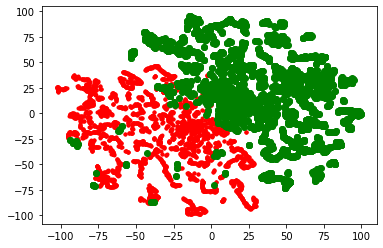

In [157]:
# step4 对检测出的helmet进行kmeans聚类，分为主队客队
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE 
from nltk.cluster.kmeans import KMeansClusterer

def apply_kmeans(df):
    cols = []
    for i in range(512):
        cols.append(f'feature{i+1}')
    x = df[cols]
    
    # k_means = KMeans(n_clusters=2)
    k_means = KMedoids(n_clusters=2, metric='cosine')
#     k_means = KMeansClusterer(num_means=2, distance=cosine_distance)
    k_means.fit(x)
    y_predict = k_means.predict(x)
    return x, y_predict, k_means

kmeans_data = matched_res.copy()
x, y_predict, kmeans_model = apply_kmeans(kmeans_data)
kmeans_data['cluster'] = y_predict
s = silhouette_score(x, y_predict, metric='cosine')
print(f"轮廓系数为:{s:.4f}")

tsne = TSNE()
tsne.fit_transform(x) #进行数据降维,并返回结果
tsne = pd.DataFrame(tsne.embedding_) #转换数据格式
d = tsne[y_predict == 0]
plt.plot(d[0], d[1], 'r.')
d = tsne[y_predict == 1]
plt.plot(d[0], d[1], 'go')
plt.show()
# kmeans_data

In [158]:
kmeans_data['team'] = kmeans_data['player'].map(lambda x: x[0])
# kmeans_data
zero_class = kmeans_data[kmeans_data.cluster == 0]['team'].value_counts().index[0]
one_class = kmeans_data[kmeans_data.cluster == 1]['team'].value_counts().index[0]
# zero_class,one_class
classes = [zero_class, one_class]

# 预测所有的helmets的主客队类别

detections_team_type = detections.copy()
cols = []
for i in range(512):
    cols.append(f'feature{i+1}')
x = detections_team_type[cols]
y = kmeans_model.predict(x)

detections_team_type['cluster'] = y
detections_team_type['team'] = detections_team_type['cluster'].map(lambda x: classes[int(x)])
# detections_team_type

In [159]:
trackings['team'] = trackings['player'].map(lambda x: x[0])
trackings['cluster'] = trackings['team'].apply(lambda x: classes.index(x))

# step5 重新计算icp和匈牙利算法
NEED_CLUSTER = True
p = Pool(processes=32)
res_list = []
tracking_list = []
df_list = list(detections_team_type.groupby(['video_frame']))
with tqdm(total=len(df_list)) as pbar:
    for this_df in p.imap(cal_icp, df_list):
        this_detection, this_tracking = this_df
        res_list.append(this_detection)
        tracking_list.append(this_tracking)
        pbar.update(1)
p.close()
        
icp_res_2 = pd.concat(res_list)
icp_tracking = pd.concat(tracking_list)

# 重新匹配
matched_list = []    
p = Pool(processes=32)
df_list = list(icp_res_2.groupby(['video_frame']))
with tqdm(total=len(df_list)) as pbar:
    for this_df in p.imap(match, df_list):
        matched_list.append(this_df)
        pbar.update(1)
p.close()
        
matched_res_2 = pd.concat(matched_list)
            
matched_res_2

  0%|          | 0/548 [00:00<?, ?it/s]

  0%|          | 0/548 [00:00<?, ?it/s]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feat

In [160]:
#! 这部分未完成，没启用
NEED_CLUSTER = False
# 使用匈牙利算法重新匹配头盔和追踪数据，cost matrix的计算使用label出现的概率
res = []
for video, df in matched_res_2.groupby(['video']):
    df = df.drop(columns=['match'])
    deepsort_clusters = df['deepsort_cluster'].drop_duplicates().tolist()
    players = matched_res_2.player.drop_duplicates().tolist()
    # print(deepsort_clusters)
    # print(players)
    
    cost_matrix = pd.DataFrame(index=deepsort_clusters, columns=players)

    # 计算每个deepsort cluster 球员
    for cls_id in deepsort_clusters:
        count = df[df.deepsort_cluster == cls_id].player.value_counts()
        # print(count)
        for ply, c in count.iteritems():
            cost_matrix.loc[cls_id, ply] = c 
    cost_matrix = cost_matrix.fillna(0)
    # print(cost_matrix)
    # print(cost_matrix.sum(axis=1).shape)
    
    cost_matrix = cost_matrix / cost_matrix.sum(axis=1).values.reshape((-1, 1))
    cost_matrix = 1 - cost_matrix
#     print(cost_matrix)
#     matched_list = []    
#     p = Pool(processes=32)
#     df_list = list(icp_res.groupby(['video_frame']))
#     with tqdm(total=len(df_list)) as pbar:
#         for this_df in p.imap(match, df_list):
#             matched_list.append(this_df)
#             pbar.update(1)
#     p.close()
    
    for video_frame, video_frame_df in df.groupby(['video_frame']):
        frame = int(video_frame.split('_')[-1])
        if frame == 1:
            res.append(video_frame_df)
            continue
        tracking_data = matched_res_2[matched_res_2.video_frame == video_frame][['idx', 'player', 'x_y', 'y_y']].drop_duplicates('player').reset_index(drop=True)
        tracking_data = tracking_data.rename(columns={"x_y":"x", "y_y":"y"})
        
        detected_data = video_frame_df.drop(columns=['idx', 'player', 'x_y', 'y_y'])
        detected_data = detected_data.rename(columns={"x_x":"x", "y_x":"y"})
        
        cm = cost_matrix.loc[detected_data.deepsort_cluster, :]
        # print(cm)
        # print(detected_data.deepsort_cluster)
        # print(tracking_data)
        
        res_detected = apply_match(detected_data, tracking_data, cm.values) 
        res.append(res_detected)
        # print(res_detected[['deepsort_cluster', 'player']])
        # break

res = pd.concat(res)
res

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,feature40,feature41,feature42,feature43,feature44,feature45,feature46,feature47,feature48,feature49,feature50,feature51,feature52,feature53,feature54,feature55,feature56,feature57,feature58,feature59,feature60,feature61,feature62,feature63,feature64,feature65,feature66,feature67,feature68,feature69,feature70,feature71,feature72,feature73,feature74,feature75,feature76,feature77,feature78,feature79,feature80,feature81,feature82,feature83,feature84,feature85,feature86,feature87,feature88,feature89,feature90,feature91,feature92,feature93,feature94,feature95,feature96,feature97,feature98,feature99,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,feature108,feature109,feature110,feature111,feature112,feature113,feature114,feature115,feature116,feature117,feature118,feature119,feature120,feature121,feature122,feature123,feature124,feature125,feature126,feature127,feature128,feature129,feature130,feature131,feature132,feature133,feature134,feature135,feature136,feature137,feature138,feature139,feature140,feature141,feature142,feature143,feature144,feature145,feature146,feature147,feature148,feature149,feature150,feature151,feature152,feature153,feature154,feature155,feature156,feature157,feature158,feature159,feature160,feature161,feature162,feature163,feature164,feature165,feature166,feature167,feature168,feature169,feature170,feature171,feature172,feature173,feature174,feature175,feature176,feature177,feature178,feature179,feature180,feature181,feature182,feature183,feature184,feature185,feature186,feature187,feature188,feature189,feature190,feature191,feature192,feature193,feature194,feature195,feature196,feature197,feature198,feature199,feature200,feature201,feature202,feature203,feature204,feature205,feature206,feature207,feature208,feature209,feature210,feature211,feature212,feature213,feature214,feature215,feature216,feature217,feature218,feature219,feature220,feature221,feature222,feature223,feature224,feature225,feature226,feature227,feature228,feature229,feature230,feature231,feature232,feature233,feature234,feature235,feature236,feature237,feature238,feature239,feature240,feature241,feature242,feature243,feature244,feature245,feature246,feature247,feature248,feature249,feature250,feature251,feature252,feature253,feature254,feature255,feature256,feature257,feature258,feature259,feature260,feature261,feature262,feature263,feature264,feature265,feature266,feature267,feature268,feature269,feature270,feature271,feature272,feature273,feature274,feature275,feature276,feature277,feature278,feature279,feature280,feature281,feature282,feature283,feature284,feature285,feature286,feature287,feature288,feature289,feature290,feature291,feature292,feature293,feature294,feature295,feature296,feature297,feature298,feature299,feature300,feature301,feature302,feature303,feature304,feature305,feature306,feature307,feature308,feature309,feature310,feature311,feature312,feature313,feature314,feature315,feature316,feature317,feature318,feature319,feature320,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,feature330,feature331,feature332,feature333,feature334,feature335,feature336,feature337,feature338,feature339,feature340,feature341,feature342,feature343,feature344,feature345,feature346,feature347,feature348,feature349,feature350,feature351,feature352,feature353,feature354,feature355,feature356,feature357,feature358,feature359,feature360,feature361,feature362,feature363,feature364,feature365,feature366,feature367,feature368,feature369,feature370,feature371,feature372,feature373,feat

In [161]:
# 对deepsort的结果label基于出现的概率重新assign
def add_deepsort_label_col(out):
    # Find the top occuring label for each deepsort_cluster
    sortlabel_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label'].to_dict()
    # Find the # of times that label appears for the deepsort_cluster.
    sortlabelcount_map = out.groupby('deepsort_cluster')['label'].value_counts() \
        .sort_values(ascending=False).to_frame() \
        .rename(columns={'label':'label_count'}) \
        .reset_index() \
        .groupby(['deepsort_cluster']) \
        .first()['label_count'].to_dict()
    
    out['label_deepsort'] = out['deepsort_cluster'].map(sortlabel_map)
    out['label_count_deepsort'] = out['deepsort_cluster'].map(sortlabelcount_map)

    return out

In [162]:
submission_df = matched_res_2.copy()
ss = pd.read_csv('nfl-health-and-safety-helmet-assignment/sample_submission.csv')

submission_df = submission_df[submission_df.top+submission_df.height < 720]
submission_df = submission_df.rename(columns={"player": "label"})

submission_df = submission_df[['video_frame','left','width','top','height','label', 'deepsort_cluster']]

add_deepsort_label_col(submission_df)


submission_df['label_deepsort'] = submission_df['label_deepsort'] \
    .fillna(submission_df['label'])
submission_df = submission_df.drop('label', axis=1) \
    .rename(columns={'label_deepsort':'label'})[ss.columns]
# Drop duplicate labels
submission_df = submission_df.loc[
    ~submission_df[['video_frame','label']].duplicated()]
check_submission(submission_df)


if debug:
    scorer = NFLAssignmentScorer(labels)
    baseline_score = scorer.score(submission_df)
    print(f"validation score {baseline_score:0.4f}")
# submission_df

validation score 0.4036
